# Autoencoders and GANs
Explore how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining or as generative models. Then, understand adversial training and build a simple GAN to generate fake images.

## What are Autoencoders?
Data around us, like images and documents, are very high dimensions. Autoencoders can learn a simple representation of it. They are a class of "unsupervised" neural networks.

The architecture consists of 3 parts:
1. Encoder
2. A bottleneck
3. Decoder

![Autoencoders Schema](images/autoencoder-architecture.png)
The output consists of a reconstructed input. Hence it has the same dimensions.The objective is to learn a representation that will minimize the reconstruction loss.

If the number of neurons in the hidden layer are less than that of the input layer, the autoencoder is said to be *undercomplete*.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

### PCA with a linear Autoencoder
If the decoder phase does not use the activation function and the cost function is the mean squared error (MSE), then it ends up performing PCA.

In [24]:
# Build 3D dataset:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data
    
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [25]:
# building an encoder
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([ keras.layers.Dense(2, input_shape=[3]) ])
decoder = keras.models.Sequential([ keras.layers.Dense(3, input_shape=[2]) ])

autoencoder = keras.models.Sequential([encoder, decoder])

# loss = mse and no activation
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))

In [26]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 0.3019
Epoch 2/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2836
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2667
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2520
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2370
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2234
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2098
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1968
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1722
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1605
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1498
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [27]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


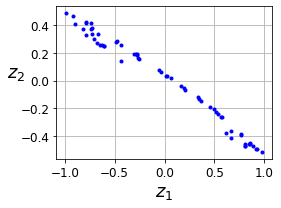

In [29]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

### Stacked Autoencoders
Autoencoders can have multiple hidden layers. Adding more layers help the autoencoder learn more complex codings. The architecture is typically symmetrical with regard to the central hidden layer.

In [30]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [32]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [34]:
# using MNIST data
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # flatten 28 x 28 image
    keras.layers.Dense(100, activation='selu'), # process through 2 dense layers of diminishing sizes i.e 100 and 30
    keras.layers.Dense(30, activation='selu') # output vector of size 30
])

stacked_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(784, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

# we are treating the reconstruction task as multilabel binary classification problem:
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy]) 

history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3354 - rounded_accuracy: 0.8897 - val_loss: 0.3178 - val_rounded_accuracy: 0.8983
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3046 - rounded_accuracy: 0.9161 - val_loss: 0.3015 - val_rounded_accuracy: 0.9217
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.3007 - val_rounded_accuracy: 0.9155
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2937 - rounded_accuracy: 0.9257 - val_loss: 0.2928 - val_rounded_accuracy: 0.9285
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2911 - rounded_accuracy: 0.9280 - val_loss: 0.2908 - val_rounded_accuracy: 0.9291
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2890 - rounded_accuracy: 0.9298 - val_loss: 0.2897 - val_rounded_accuracy: 0.9319
Epoch 7/10
1719/1719 [==================

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [35]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


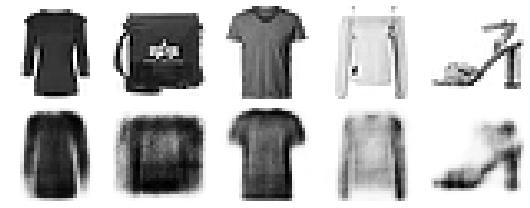

In [37]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

The above model is too lossy. But if we make the network too powerful, it will not learn any useful patterns in data.

### Visualizing the Fashion MNIST Dataset
We first use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use scikit-learns implementation fo t-SNE algorithm to reduce the dimensionality down to 2 for visualization:

In [53]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)

tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

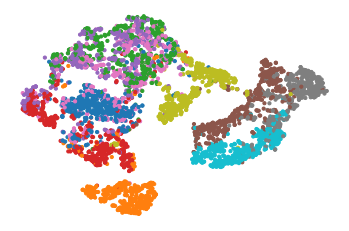

In [55]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.axis("off")
plt.show()

### Tying Weights